In [1]:
import numpy as np, healpy as hp, os, prjlib, pickle, curvedsky, plottools as pl, tools_cmb, tqdm
from astropy.io import fits
from matplotlib.pyplot import *
%matplotlib inline

In [2]:
p = prjlib.init_analysis(dtype='dr3_nosz',wtype='Lmask',snmax=10)
hdu = fits.open(p.fimap['s'][0])

In [3]:
hdu.info()

Filename: /global/cscratch1/sd/toshiyan/plk/input/COM_CMB_IQU-smica-nosz_2048_R3.00_full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1                1 BinTableHDU     35   50331648R x 2C   [1E, 1E]   


In [4]:
cmbmap = tools_cmb.reduc_map('dr3_nosz',p.fimap['s'][0])
w, M, wn = prjlib.set_mask(p.famask)

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/healpy/fitsfunc.py:367: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


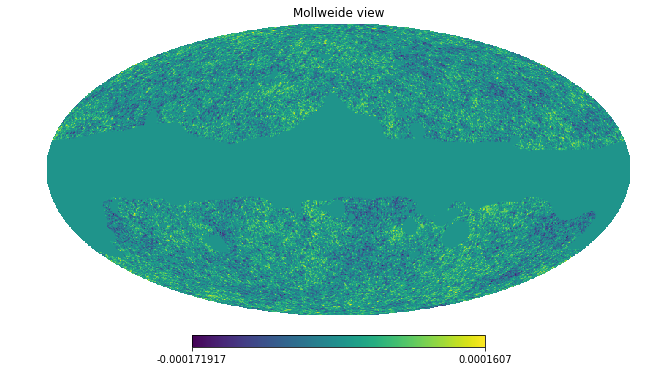

In [5]:
hp.mollview(w*cmbmap)

In [6]:
lmax = 2048
alm = curvedsky.utils.hp_map2alm(2048,lmax,lmax,w*cmbmap)

In [7]:
l = np.linspace(0,lmax,lmax+1)
ibl = 1./np.loadtxt(p.fbeam)[:lmax+1]
cl = curvedsky.utils.alm2cl(lmax,alm)*ibl**2/wn[2]
np.savetxt(p.fcmb.ocl,np.array((l,cl)).T)

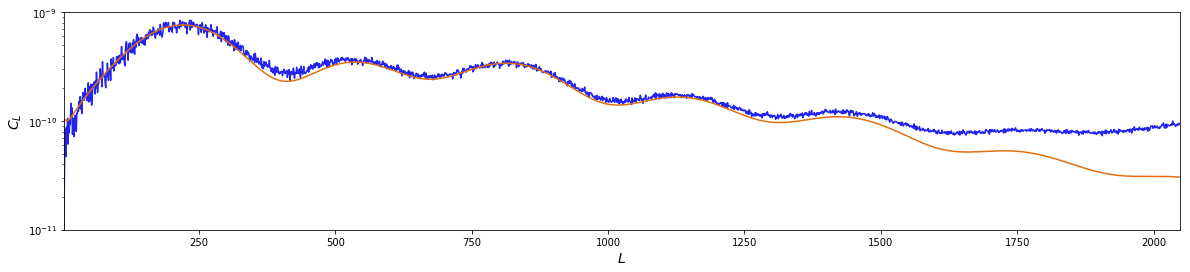

In [8]:
pl.plot_1dstyle(fsize=[20,4],ymin=1e-11,ymax=1e-9,xmin=2,ylog=True,xmax=2048)
plot(l,l**2*cl/2/np.pi)
plot(l,l**2*p.lcl[0,:]/2/np.pi)

In [9]:
import scipy.signal as sp
lmin = 800
rcl = (np.loadtxt(p.fcmb.ocl)).T[1]
lmax = len(rcl) - 1
# interpolate
dCL = rcl - p.lcl[0,:]
dcl = sp.savgol_filter(dCL, 101, 1)
dcl[dcl<=0] = 1e-30
dcl[:lmin]  = 1e-30
np.savetxt(p.fnosz_nl,np.array((np.linspace(0,lmax,lmax+1),dcl,dCL)).T)
dcl = np.sqrt(dcl)

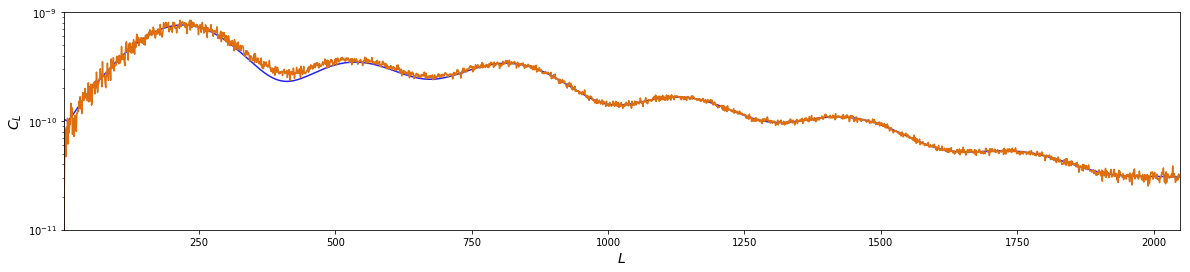

In [10]:
#l, scl0, ncl0, ocl0, vcl0 = np.loadtxt(p.fcmb.scl,unpack=True,usecols=(0,1,2,4,8))
#l, rcl0 = np.loadtxt(p.fcmb.ocl,unpack=True,usecols=(0,1))
pl.plot_1dstyle(fsize=[20,4],ymin=1e-11,ymax=1e-9,xmin=2,ylog=True,xmax=2048)
plot(l,l**2*p.lcl[0,:]/2/np.pi)
plot(l,l**2*(cl-dcl**2)/2/np.pi)
#plot(l,l**2*rcl0/2/np.pi)
#plot(l,l**2*ncl0*2.7**2/1.03**2/2/np.pi)
#plot(l,l**2*dcl**2/2/np.pi)

In [11]:
# generating seed, only for the first run
for i in p.rlz:
    if not os.path.exists(p.fnseed[i]):
        alm = curvedsky.utils.gauss1alm(lmax,np.ones(lmax+1))
        pickle.dump((alm),open(p.fnseed[i],"wb"),protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# load beam function
bl = np.loadtxt(p.fbeam)[:lmax+1]
nside = 2048
# multiply cl, transform to map and save it
for i in tqdm.tqdm(p.rlz,ncols=100,desc='gen noise for nosz:'):

    if i==0: continue

    palm = pickle.load(open(p.fnseed[i],"rb"))
    palm *= dcl[:,None]*bl[:,None] #multiply beam-convolved cl
    pmap = curvedsky.utils.hp_alm2map(nside,lmax,lmax,palm) * 2.726
    hp.fitsfunc.write_map(p.fimap['n'][i],pmap,overwrite=True)

gen noise for nosz:: 100%|██████████████████████████████████████████| 11/11 [02:39<00:00, 14.54s/it]
